In [1]:
pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224708 sha256=79f7355f5f75e69d7d9064f5114bc104212cb2732a1424046e0fde6190612f6a
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *
from typing import List, Tuple, Union
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
from pdb import set_trace as st

from torch.nn import init


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

class KANLayer(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., no_kan=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        
        grid_size=5
        spline_order=3
        scale_noise=0.1
        scale_base=1.0
        scale_spline=1.0
        base_activation=torch.nn.SiLU
        grid_eps=0.02
        grid_range=[-1, 1]

        if not no_kan:
            self.fc1 = KANLinear(
                        in_features,
                        hidden_features,
                        grid_size=grid_size,
                        spline_order=spline_order,
                        scale_noise=scale_noise,
                        scale_base=scale_base,
                        scale_spline=scale_spline,
                        base_activation=base_activation,
                        grid_eps=grid_eps,
                        grid_range=grid_range,
                    )
            self.fc2 = KANLinear(
                        hidden_features,
                        out_features,
                        grid_size=grid_size,
                        spline_order=spline_order,
                        scale_noise=scale_noise,
                        scale_base=scale_base,
                        scale_spline=scale_spline,
                        base_activation=base_activation,
                        grid_eps=grid_eps,
                        grid_range=grid_range,
                    )
            self.fc3 = KANLinear(
                        hidden_features,
                        out_features,
                        grid_size=grid_size,
                        spline_order=spline_order,
                        scale_noise=scale_noise,
                        scale_base=scale_base,
                        scale_spline=scale_spline,
                        base_activation=base_activation,
                        grid_eps=grid_eps,
                        grid_range=grid_range,
                    )
            # # TODO   
            # self.fc4 = KANLinear(
            #             hidden_features,
            #             out_features,
            #             grid_size=grid_size,
            #             spline_order=spline_order,
            #             scale_noise=scale_noise,
            #             scale_base=scale_base,
            #             scale_spline=scale_spline,
            #             base_activation=base_activation,
            #             grid_eps=grid_eps,
            #             grid_range=grid_range,
            #         )   

        else:
            self.fc1 = nn.Linear(in_features, hidden_features)
            self.fc2 = nn.Linear(hidden_features, out_features)
            self.fc3 = nn.Linear(hidden_features, out_features)

        # TODO
        # self.fc1 = nn.Linear(in_features, hidden_features)


        self.dwconv_1 = DW_bn_relu(hidden_features)
        self.dwconv_2 = DW_bn_relu(hidden_features)
        self.dwconv_3 = DW_bn_relu(hidden_features)

        # # TODO
        # self.dwconv_4 = DW_bn_relu(hidden_features)
    
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        x = self.fc1(x.reshape(B*N,C))
        x = x.reshape(B,N,C).contiguous()
        x = self.dwconv_1(x, H, W)
        x = self.fc2(x.reshape(B*N,C))
        x = x.reshape(B,N,C).contiguous()
        x = self.dwconv_2(x, H, W)
        x = self.fc3(x.reshape(B*N,C))
        x = x.reshape(B,N,C).contiguous()
        x = self.dwconv_3(x, H, W)

        # # TODO
        # x = x.reshape(B,N,C).contiguous()
        # x = self.dwconv_4(x, H, W)
    
        return x

class KANBlock(nn.Module):
    def __init__(self, dim, drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, no_kan=False):
        super().__init__()

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim)

        self.layer = KANLayer(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, no_kan=no_kan)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.layer(self.norm2(x), H, W))

        return x


class PolynomialFunction(nn.Module):
    def __init__(self, 
                 degree: int = 3):
        super().__init__()
        self.degree = degree

    def forward(self, x):
        return torch.stack([x ** i for i in range(self.degree)], dim=-1)
    
class BSplineFunction(nn.Module):
    def __init__(self, grid_min: float = -2.,
        grid_max: float = 2., degree: int = 3, num_basis: int = 8):
        super(BSplineFunction, self).__init__()
        self.degree = degree
        self.num_basis = num_basis
        self.knots = torch.linspace(grid_min, grid_max, num_basis + degree + 1)  # Uniform knots

    def basis_function(self, i, k, t):
        if k == 0:
            return ((self.knots[i] <= t) & (t < self.knots[i + 1])).float()
        else:
            left_num = (t - self.knots[i]) * self.basis_function(i, k - 1, t)
            left_den = self.knots[i + k] - self.knots[i]
            left = left_num / left_den if left_den != 0 else 0

            right_num = (self.knots[i + k + 1] - t) * self.basis_function(i + 1, k - 1, t)
            right_den = self.knots[i + k + 1] - self.knots[i + 1]
            right = right_num / right_den if right_den != 0 else 0
            return left + right 
    
    def forward(self, x):
        x = x.squeeze()  # Assuming x is of shape (B, 1)
        basis_functions = torch.stack([self.basis_function(i, self.degree, x) for i in range(self.num_basis)], dim=-1)
        return basis_functions

class ChebyshevFunction(nn.Module):
    def __init__(self, degree: int = 4):
        super(ChebyshevFunction, self).__init__()
        self.degree = degree

    def forward(self, x):
        chebyshev_polynomials = [torch.ones_like(x), x]
        for n in range(2, self.degree):
            chebyshev_polynomials.append(2 * x * chebyshev_polynomials[-1] - chebyshev_polynomials[-2])
        return torch.stack(chebyshev_polynomials, dim=-1)

class FourierBasisFunction(nn.Module):
    def __init__(self, 
                 num_frequencies: int = 4, 
                 period: float = 1.0):
        super(FourierBasisFunction, self).__init__()
        assert num_frequencies % 2 == 0, "num_frequencies must be even"
        self.num_frequencies = num_frequencies
        self.period = nn.Parameter(torch.Tensor([period]), requires_grad=False)

    def forward(self, x):
        frequencies = torch.arange(1, self.num_frequencies // 2 + 1, device=x.device)
        sin_components = torch.sin(2 * torch.pi * frequencies * x[..., None] / self.period)
        cos_components = torch.cos(2 * torch.pi * frequencies * x[..., None] / self.period)
        basis_functions = torch.cat([sin_components, cos_components], dim=-1)
        return basis_functions
        
class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 4,
        denominator: float = None,
    ):
        super().__init__()
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)
    

    
    
class SplineConv2D(nn.Conv2d):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 init_scale: float = 0.1, 
                 padding_mode: str = "zeros", 
                 **kw
                 ) -> None:
        self.init_scale = init_scale
        super().__init__(in_channels, 
                         out_channels, 
                         kernel_size, 
                         stride, 
                         padding, 
                         dilation, 
                         groups, 
                         bias, 
                         padding_mode, 
                         **kw
                         )

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)


class FastKANConvLayer(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 grid_min: float = -2., 
                 grid_max: float = 2.,
                 num_grids: int = 4, 
                 use_base_update: bool = True, 
                 base_activation = F.silu,
                 spline_weight_init_scale: float = 0.1, 
                 padding_mode: str = "zeros",
                 kan_type: str = "BSpline",
                #  kan_type: str = "RBF",
                 ) -> None:
        
        super().__init__()
        if kan_type == "RBF":
            self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        elif kan_type == "Fourier":
            self.rbf = FourierBasisFunction(num_grids)
        elif kan_type == "Poly":
            self.rbf = PolynomialFunction(num_grids)
        elif kan_type == "Chebyshev":
            self.rbf = ChebyshevFunction(num_grids)
        elif kan_type == "BSpline":
            self.rbf = BSplineFunction(grid_min, grid_max, 3, num_grids)

        self.spline_conv = SplineConv2D(in_channels * num_grids, 
                                        out_channels, 
                                        kernel_size,
                                        stride, 
                                        padding, 
                                        dilation, 
                                        groups, 
                                        bias,
                                        spline_weight_init_scale, 
                                        padding_mode)
        
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_conv = nn.Conv2d(in_channels, 
                                       out_channels, 
                                       kernel_size, 
                                       stride, 
                                       padding, 
                                       dilation, 
                                       groups, 
                                       bias, 
                                       padding_mode)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x_rbf = self.rbf(x.view(batch_size, channels, -1)).view(batch_size, channels, height, width, -1)
        x_rbf = x_rbf.permute(0, 4, 1, 2, 3).contiguous().view(batch_size, -1, height, width)
        
        # Apply spline convolution
        ret = self.spline_conv(x_rbf)
         
        if self.use_base_update:
            base = self.base_conv(self.base_activation(x))
            ret = ret + base
        
        return ret


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class DW_bn_relu(nn.Module):
    def __init__(self, dim=768):
        super(DW_bn_relu, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)
        self.bn = nn.BatchNorm2d(dim)
        self.relu = nn.ReLU()

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class KConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(KConvLayer, self).__init__()
        self.conv = FastKANConvLayer(in_ch, out_ch, 3, padding=1, kan_type = "BSpline")

    def forward(self, input):
        return self.conv(input)
    
class ConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class KD_ConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(KD_ConvLayer, self).__init__()
        self.conv = FastKANConvLayer(in_ch, out_ch, 3, padding=1, kan_type = "BSpline")

    def forward(self, input):
        return self.conv(input)
    
class D_ConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(D_ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)



class UKAN(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, img_size=224, patch_size=16, in_chans=3, embed_dims=[256, 320, 512], no_kan=False,
    drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm, depths=[1, 1, 1], **kwargs):
        super().__init__()

        kan_input_dim = embed_dims[0]

        self.encoder1 = ConvLayer(3, kan_input_dim//8)  
        self.encoder2 = ConvLayer(kan_input_dim//8, kan_input_dim//4)  
        self.encoder3 = ConvLayer(kan_input_dim//4, kan_input_dim)

        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(embed_dims[1])
        self.dnorm4 = norm_layer(embed_dims[0])

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([KANBlock(
            dim=embed_dims[1], 
            drop=drop_rate, drop_path=dpr[0], norm_layer=norm_layer
            )])

        self.block2 = nn.ModuleList([KANBlock(
            dim=embed_dims[2],
            drop=drop_rate, drop_path=dpr[1], norm_layer=norm_layer
            )])

        self.dblock1 = nn.ModuleList([KANBlock(
            dim=embed_dims[1], 
            drop=drop_rate, drop_path=dpr[0], norm_layer=norm_layer
            )])

        self.dblock2 = nn.ModuleList([KANBlock(
            dim=embed_dims[0], 
            drop=drop_rate, drop_path=dpr[1], norm_layer=norm_layer
            )])

        self.patch_embed3 = PatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
        self.patch_embed4 = PatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])

        self.decoder1 = D_ConvLayer(embed_dims[2], embed_dims[1])  
        self.decoder2 = D_ConvLayer(embed_dims[1], embed_dims[0])  
        self.decoder3 = D_ConvLayer(embed_dims[0], embed_dims[0]//4) 
        self.decoder4 = D_ConvLayer(embed_dims[0]//4, embed_dims[0]//8)
        self.decoder5 = D_ConvLayer(embed_dims[0]//8, embed_dims[0]//8)

        self.final = nn.Conv2d(embed_dims[0]//8, num_classes, kernel_size=1)
        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.encoder1(x), 2, 2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.encoder2(out), 2, 2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.encoder3(out), 2, 2))
        t3 = out

        ### Tokenized KAN Stage
        ### Stage 4

        out, H, W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out, H, W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4
        out = F.relu(F.interpolate(self.decoder1(out), scale_factor=(2,2), mode ='bilinear'))

        out = torch.add(out, t4)
        _, _, H, W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.decoder2(out),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.decoder3(out),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.decoder4(out),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


In [3]:
model = UKAN(num_classes = 1, input_channels = 3, deep_supervision = 3, input_list = [128, 160, 256], no_kan=False)

In [4]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Số lượng tham số của mô hình: {total_params}")

Số lượng tham số của mô hình: 25359265


In [5]:
from albumentations.augmentations import transforms
from albumentations.augmentations import geometric
from albumentations import RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

train_transform = Compose([
        RandomRotate90(),
        geometric.transforms.Flip(),
        Resize(224, 224),
        transforms.Normalize(),
    ])

val_transform = Compose([
        Resize(224, 224),
        transforms.Normalize(),
    ])

In [6]:
import os

import cv2
import numpy as np
import torch
import torch.utils.data

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, num_classes, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, img_id + self.img_ext)
        img = cv2.imread(img_path)
        
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        mask = []
        for i in range(self.num_classes):
            mask_path = os.path.join(self.mask_dir, img_id + self.mask_ext)
            mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask_img is None:
                raise FileNotFoundError(f"Mask not found: {mask_path}")
            
            mask.append(mask_img[..., None])
            
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        if mask.max() < 1:
            mask[mask > 0] = 1.0

        return img, mask, {'img_id': img_id}

In [7]:
from sklearn.model_selection import train_test_split
from glob import glob


data_dir = '/kaggle/input/cvcclinicdb/TIF'
img_ext = '.tif'
mask_ext = '.tif'
num_classes = 1

img_ids = sorted(glob(os.path.join(data_dir, 'Original', '*' + img_ext)))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

In [8]:
train_dataset = Dataset(
        img_ids=train_img_ids,
        img_dir=os.path.join(data_dir,'Original'),
        mask_dir=os.path.join(data_dir,'Ground Truth'),
        img_ext=img_ext,
        mask_ext=mask_ext,
        num_classes=num_classes,
        transform=train_transform)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=0,
        drop_last=True)

val_dataset = Dataset(
        img_ids=val_img_ids,
        img_dir=os.path.join(data_dir,'Original'),
        mask_dir=os.path.join(data_dir,'Ground Truth'),
        img_ext=img_ext,
        mask_ext=mask_ext,
        num_classes=num_classes,
        transform=val_transform)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    drop_last=False)

In [9]:
import argparse
import torch.nn as nn
from collections import OrderedDict


class qkv_transform(nn.Conv1d):
    """Conv1d for qkv_transform"""

def str2bool(v):
    if v.lower() in ['true', 1]:
        return True
    elif v.lower() in ['false', 0]:
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import numpy as np
import torch
import torch.nn.functional as F

from medpy.metric.binary import jc, dc, hd, hd95, recall, specificity, precision



def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()
    iou = (intersection + smooth) / (union + smooth)
    dice = (2* iou) / (iou+1)

    try:
        hd95_ = hd95(output_, target_)
    except:
        hd95_ = 0
    
    return iou, dice, hd95_


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

def indicators(output, target):
    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5

    iou_ = jc(output_, target_)
    dice_ = dc(output_, target_)
#     hd_ = hd(output_, target_)
#     hd95_ = hd95(output_, target_)
    recall_ = recall(output_, target_)
    specificity_ = specificity(output_, target_)
    precision_ = precision(output_, target_)

    return iou_, dice_, recall_, specificity_, precision_

In [10]:
import torch.optim as optim
from collections import OrderedDict

In [11]:
def validate(val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    # Đặt mô hình ở chế độ evaluation (không tính gradient)
    model.eval()

    with torch.no_grad():
        for input, target, _ in tqdm(val_loader):
            input = input.cuda()
            target = target.cuda()

            # Tính toán output từ model
            output = model(input)
            loss = criterion(output, target)

            # Tính IoU, Dice
            iou, dice, _ = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

In [12]:
log = OrderedDict([
        ('epoch', []),
        ('lr', []),
        ('loss', []),
        ('iou', []),
        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
    ])


best_iou = 0
best_dice= 0
trigger = 0

def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    for input, target, _ in tqdm(train_loader):
        input = input.cuda()
        target = target.cuda()
        # compute output
        if config:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)

            iou, dice, _ = iou_score(outputs[-1], target)
#             iou_, dice_, hd95_, recall_, specificity_, precision_ = indicators(outputs[-1], target)
            
        else:
            output = model(input)
            loss = criterion(output, target)
            iou, dice, _ = iou_score(output, target)
#             iou_, dice_, hd95_, recall_, specificity_, precision_ = indicators(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))
        
        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])


    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])

param_groups = []
kan_fc_params = []
other_params = []
weight_decay = 0
kan_weight_decay = 0
kan_lr = 0.0001
lr = 0.001
for name, param in model.named_parameters():
        # print(name, "=>", param.shape)
    if 'layer' in name.lower() and 'fc' in name.lower(): # higher lr for kan layers
            # kan_fc_params.append(name)
        param_groups.append({'params': param, 'lr': kan_lr, 'weight_decay': kan_weight_decay}) 
    else:
            # other_params.append(name)
        param_groups.append({'params': param, 'lr': lr, 'weight_decay': weight_decay})  
            
optimizer = optim.Adam(param_groups)
criterion = nn.BCEWithLogitsLoss().cuda()



In [13]:
model.to('cuda')

UKAN(
  (encoder1): ConvLayer(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder2): ConvLayer(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder3): ConvLayer(
    (conv): Sequential(
      (0): Conv2d(64, 256, kernel_si

In [14]:
from tensorboardX import SummaryWriter
import pandas as pd
from tqdm import tqdm
import torch.optim as optim


config = False
model.to('cuda')
criterion = nn.BCEWithLogitsLoss().cuda()

for epoch in range(300):
    print('Epoch [%d/%d]' % (epoch, 100))
    model.train()
    
    # Huấn luyện với train_loader
    train_log = train(config, train_loader, model, criterion, optimizer)
    print('Train: loss %.4f - iou %.4f' % (train_log['loss'], train_log['iou']))

    # Đánh giá với val_loader
    val_log = validate(val_loader, model, criterion)
    print('Val: loss %.4f - iou %.4f - dice %.4f' % (val_log['loss'], val_log['iou'], val_log['dice']))

    # Lưu mô hình tốt nhất dựa trên IoU
    if val_log['iou'] > best_iou:
        best_iou = val_log['iou']
        torch.save(model.state_dict(), 'best_model.pth')
        print("=> saved best model ", best_iou)
    
    torch.cuda.empty_cache()

Epoch [0/100]


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


Train: loss 0.5138 - iou 0.2337


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Val: loss 0.4327 - iou 0.0000 - dice 0.0000
=> saved best model  1.5705850937024174e-10
Epoch [1/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.3764 - iou 0.2648


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.3796 - iou 0.0937 - dice 0.1697
=> saved best model  0.09368416098803162
Epoch [2/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.3142 - iou 0.2574


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Val: loss 0.3006 - iou 0.0012 - dice 0.0024
Epoch [3/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.2719 - iou 0.2628


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Val: loss 0.2714 - iou 0.0985 - dice 0.1717
=> saved best model  0.09854244171469212
Epoch [4/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.2486 - iou 0.2685


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.2535 - iou 0.2629 - dice 0.4102
=> saved best model  0.26290119578875437
Epoch [5/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.2332 - iou 0.2762


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Val: loss 0.2249 - iou 0.1581 - dice 0.2683
Epoch [6/100]


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Train: loss 0.2174 - iou 0.2935


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Val: loss 0.2594 - iou 0.2120 - dice 0.3413
Epoch [7/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.2142 - iou 0.3057


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.2583 - iou 0.2309 - dice 0.3675
Epoch [8/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.2011 - iou 0.3453


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Val: loss 0.2694 - iou 0.0374 - dice 0.0692
Epoch [9/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.1864 - iou 0.3631


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2373 - iou 0.3161 - dice 0.4764
=> saved best model  0.3161346930923093
Epoch [10/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.1845 - iou 0.3817


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Val: loss 0.2393 - iou 0.0248 - dice 0.0476
Epoch [11/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.1819 - iou 0.3662


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Val: loss 0.3445 - iou 0.0057 - dice 0.0112
Epoch [12/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.1679 - iou 0.4535


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Val: loss 0.3324 - iou 0.0021 - dice 0.0042
Epoch [13/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.1681 - iou 0.4322


100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Val: loss 0.2969 - iou 0.0000 - dice 0.0000
Epoch [14/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1555 - iou 0.4691


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1791 - iou 0.3738 - dice 0.5425
=> saved best model  0.37380008217923133
Epoch [15/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1536 - iou 0.4717


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1861 - iou 0.2803 - dice 0.4290
Epoch [16/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1442 - iou 0.5123


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.3062 - iou 0.2326 - dice 0.3765
Epoch [17/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.1380 - iou 0.5291


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.2650 - iou 0.1556 - dice 0.2645
Epoch [18/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1370 - iou 0.5422


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Val: loss 0.2319 - iou 0.1616 - dice 0.2711
Epoch [19/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1368 - iou 0.5363


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]


Val: loss 0.3567 - iou 0.0024 - dice 0.0048
Epoch [20/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1252 - iou 0.5572


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Val: loss 0.3422 - iou 0.2873 - dice 0.4406
Epoch [21/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.1135 - iou 0.6125


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.2078 - iou 0.3163 - dice 0.4772
Epoch [22/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.1125 - iou 0.6062


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Val: loss 0.1938 - iou 0.3465 - dice 0.5056
Epoch [23/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.1087 - iou 0.6102


100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Val: loss 0.4831 - iou 0.0000 - dice 0.0000
Epoch [24/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.1061 - iou 0.6334


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.3797 - iou 0.1276 - dice 0.2243
Epoch [25/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.1081 - iou 0.6317


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.3475 - iou 0.0797 - dice 0.1470
Epoch [26/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.1009 - iou 0.6481


100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


Val: loss 0.3708 - iou 0.0000 - dice 0.0000
Epoch [27/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0941 - iou 0.6674


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.2797 - iou 0.1685 - dice 0.2835
Epoch [28/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0932 - iou 0.6717


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.3101 - iou 0.1947 - dice 0.3202
Epoch [29/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0887 - iou 0.6949


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.2375 - iou 0.4051 - dice 0.5741
=> saved best model  0.40514460253243384
Epoch [30/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0847 - iou 0.7042


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2105 - iou 0.3675 - dice 0.5279
Epoch [31/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0749 - iou 0.7273


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1485 - iou 0.4704 - dice 0.6375
=> saved best model  0.47044404629640285
Epoch [32/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0726 - iou 0.7355


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.3714 - iou 0.1620 - dice 0.2685
Epoch [33/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0717 - iou 0.7476


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2363 - iou 0.3405 - dice 0.4991
Epoch [34/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0681 - iou 0.7583


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.2793 - iou 0.2823 - dice 0.4271
Epoch [35/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0707 - iou 0.7443


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.3165 - iou 0.1838 - dice 0.2994
Epoch [36/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0678 - iou 0.7495


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1960 - iou 0.3441 - dice 0.5088
Epoch [37/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0692 - iou 0.7568


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1556 - iou 0.4666 - dice 0.6311
Epoch [38/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0678 - iou 0.7491


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.2915 - iou 0.3156 - dice 0.4699
Epoch [39/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0663 - iou 0.7636


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1729 - iou 0.4918 - dice 0.6523
=> saved best model  0.4918016250375052
Epoch [40/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0663 - iou 0.7574


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.2429 - iou 0.2431 - dice 0.3768
Epoch [41/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0581 - iou 0.7839


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2432 - iou 0.3579 - dice 0.5197
Epoch [42/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0571 - iou 0.7856


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.2396 - iou 0.3056 - dice 0.4637
Epoch [43/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0545 - iou 0.7975


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.2952 - iou 0.2343 - dice 0.3743
Epoch [44/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0564 - iou 0.7950


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1438 - iou 0.5536 - dice 0.7086
=> saved best model  0.5536118324708124
Epoch [45/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0528 - iou 0.8027


100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


Val: loss 0.6161 - iou 0.0000 - dice 0.0000
Epoch [46/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0554 - iou 0.7928


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Val: loss 0.4750 - iou 0.0336 - dice 0.0638
Epoch [47/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0587 - iou 0.7780


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.5115 - iou 0.0930 - dice 0.1649
Epoch [48/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0519 - iou 0.8069


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Val: loss 0.2510 - iou 0.2609 - dice 0.4005
Epoch [49/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0541 - iou 0.8006


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Val: loss 0.6801 - iou 0.0238 - dice 0.0435
Epoch [50/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0505 - iou 0.8134


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.2118 - iou 0.4212 - dice 0.5807
Epoch [51/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0499 - iou 0.8123


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.4007 - iou 0.1346 - dice 0.2331
Epoch [52/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0417 - iou 0.8435


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1617 - iou 0.5394 - dice 0.6971
Epoch [53/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0455 - iou 0.8240


100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


Val: loss 0.5063 - iou 0.0049 - dice 0.0095
Epoch [54/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0451 - iou 0.8333


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1166 - iou 0.6288 - dice 0.7702
=> saved best model  0.6288482782600439
Epoch [55/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0467 - iou 0.8219


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1852 - iou 0.4684 - dice 0.6358
Epoch [56/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0447 - iou 0.8325


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1048 - iou 0.6480 - dice 0.7851
=> saved best model  0.6480149226973911
Epoch [57/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0430 - iou 0.8373


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.2748 - iou 0.3647 - dice 0.5274
Epoch [58/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0481 - iou 0.8200


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1951 - iou 0.4592 - dice 0.6221
Epoch [59/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0415 - iou 0.8404


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1452 - iou 0.5598 - dice 0.7112
Epoch [60/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0372 - iou 0.8533


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.3522 - iou 0.2313 - dice 0.3688
Epoch [61/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0355 - iou 0.8622


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0799 - iou 0.7130 - dice 0.8312
=> saved best model  0.7130401572357933
Epoch [62/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0336 - iou 0.8745


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.4098 - iou 0.2678 - dice 0.4173
Epoch [63/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0405 - iou 0.8425


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Val: loss 0.1955 - iou 0.4429 - dice 0.6057
Epoch [64/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0443 - iou 0.8292


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Val: loss 0.5376 - iou 0.0641 - dice 0.1166
Epoch [65/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0369 - iou 0.8546


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1518 - iou 0.5554 - dice 0.7108
Epoch [66/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0390 - iou 0.8501


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.2808 - iou 0.3932 - dice 0.5517
Epoch [67/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0364 - iou 0.8592


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1171 - iou 0.6352 - dice 0.7753
Epoch [68/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0369 - iou 0.8581


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.3262 - iou 0.3003 - dice 0.4498
Epoch [69/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0339 - iou 0.8681


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1320 - iou 0.6294 - dice 0.7697
Epoch [70/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0352 - iou 0.8680


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.4680 - iou 0.1294 - dice 0.2211
Epoch [71/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0347 - iou 0.8666


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1711 - iou 0.5471 - dice 0.7042
Epoch [72/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0419 - iou 0.8411


100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Val: loss 0.7269 - iou 0.0000 - dice 0.0000
Epoch [73/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0397 - iou 0.8441


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.4252 - iou 0.2350 - dice 0.3634
Epoch [74/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0368 - iou 0.8563


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.2771 - iou 0.4097 - dice 0.5731
Epoch [75/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0305 - iou 0.8809


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2040 - iou 0.4452 - dice 0.6139
Epoch [76/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0344 - iou 0.8652


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1764 - iou 0.5383 - dice 0.6946
Epoch [77/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0298 - iou 0.8799


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1651 - iou 0.6177 - dice 0.7592
Epoch [78/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0273 - iou 0.8930


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1868 - iou 0.5066 - dice 0.6666
Epoch [79/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0269 - iou 0.8944


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1721 - iou 0.5924 - dice 0.7357
Epoch [80/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0293 - iou 0.8841


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1342 - iou 0.6072 - dice 0.7528
Epoch [81/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0255 - iou 0.8982


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1112 - iou 0.6713 - dice 0.8027
Epoch [82/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0327 - iou 0.8734


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Val: loss 0.2075 - iou 0.4529 - dice 0.6187
Epoch [83/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0306 - iou 0.8805


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1298 - iou 0.6366 - dice 0.7758
Epoch [84/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0271 - iou 0.8947


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1112 - iou 0.6436 - dice 0.7814
Epoch [85/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0264 - iou 0.8932


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1229 - iou 0.6864 - dice 0.8129
Epoch [86/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0290 - iou 0.8832


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1892 - iou 0.4535 - dice 0.6207
Epoch [87/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0301 - iou 0.8801


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1730 - iou 0.5904 - dice 0.7405
Epoch [88/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0280 - iou 0.8895


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.4101 - iou 0.3492 - dice 0.5003
Epoch [89/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0244 - iou 0.8991


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1303 - iou 0.6542 - dice 0.7875
Epoch [90/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0306 - iou 0.8821


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Val: loss 0.8794 - iou 0.0236 - dice 0.0453
Epoch [91/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0321 - iou 0.8757


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1309 - iou 0.6284 - dice 0.7686
Epoch [92/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0266 - iou 0.8955


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.2911 - iou 0.4158 - dice 0.5808
Epoch [93/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0247 - iou 0.9034


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1484 - iou 0.6103 - dice 0.7569
Epoch [94/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0249 - iou 0.8998


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.2914 - iou 0.4131 - dice 0.5765
Epoch [95/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0234 - iou 0.9050


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1837 - iou 0.5982 - dice 0.7441
Epoch [96/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0226 - iou 0.9080


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.2814 - iou 0.4491 - dice 0.6116
Epoch [97/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0234 - iou 0.9038


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1456 - iou 0.5906 - dice 0.7408
Epoch [98/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0249 - iou 0.8991


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1585 - iou 0.5994 - dice 0.7459
Epoch [99/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0251 - iou 0.8991


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1482 - iou 0.6272 - dice 0.7674
Epoch [100/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0294 - iou 0.8816


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.3028 - iou 0.4347 - dice 0.5866
Epoch [101/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0242 - iou 0.9038


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.2519 - iou 0.4490 - dice 0.6090
Epoch [102/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0265 - iou 0.8953


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1236 - iou 0.6468 - dice 0.7830
Epoch [103/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0251 - iou 0.8960


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1775 - iou 0.5922 - dice 0.7395
Epoch [104/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0239 - iou 0.8994


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Val: loss 0.5515 - iou 0.1032 - dice 0.1838
Epoch [105/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0313 - iou 0.8807


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.3734 - iou 0.2064 - dice 0.3377
Epoch [106/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0374 - iou 0.8590


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.5610 - iou 0.1026 - dice 0.1800
Epoch [107/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0398 - iou 0.8516


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.3461 - iou 0.3075 - dice 0.4510
Epoch [108/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0293 - iou 0.8810


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1434 - iou 0.6328 - dice 0.7736
Epoch [109/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0309 - iou 0.8779


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1457 - iou 0.5481 - dice 0.7066
Epoch [110/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0370 - iou 0.8578


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1191 - iou 0.6630 - dice 0.7968
Epoch [111/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0336 - iou 0.8686


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.4170 - iou 0.2380 - dice 0.3720
Epoch [112/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0364 - iou 0.8590


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Val: loss 0.5614 - iou 0.1434 - dice 0.2348
Epoch [113/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0340 - iou 0.8683


100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Val: loss 0.7380 - iou 0.0000 - dice 0.0000
Epoch [114/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0285 - iou 0.8895


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0985 - iou 0.7334 - dice 0.8449
=> saved best model  0.733405092870679
Epoch [115/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0232 - iou 0.9056


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1380 - iou 0.6601 - dice 0.7936
Epoch [116/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0249 - iou 0.8973


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1296 - iou 0.6324 - dice 0.7717
Epoch [117/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0235 - iou 0.9038


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0858 - iou 0.7375 - dice 0.8474
=> saved best model  0.7374814282357329
Epoch [118/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0223 - iou 0.9093


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1160 - iou 0.6799 - dice 0.8045
Epoch [119/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0218 - iou 0.9107


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0785 - iou 0.7673 - dice 0.8658
=> saved best model  0.7673186382062122
Epoch [120/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0206 - iou 0.9140


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0858 - iou 0.7462 - dice 0.8531
Epoch [121/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0214 - iou 0.9138


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.2248 - iou 0.5523 - dice 0.7049
Epoch [122/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0203 - iou 0.9154


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0894 - iou 0.7693 - dice 0.8681
=> saved best model  0.769348889808112
Epoch [123/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0210 - iou 0.9124


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1115 - iou 0.7157 - dice 0.8315
Epoch [124/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0205 - iou 0.9161


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1009 - iou 0.7404 - dice 0.8484
Epoch [125/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0176 - iou 0.9257


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0761 - iou 0.7709 - dice 0.8692
=> saved best model  0.770940065293748
Epoch [126/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0190 - iou 0.9212


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.0945 - iou 0.7444 - dice 0.8517
Epoch [127/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0183 - iou 0.9227


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1382 - iou 0.6635 - dice 0.7943
Epoch [128/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0181 - iou 0.9219


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0913 - iou 0.7486 - dice 0.8549
Epoch [129/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0227 - iou 0.9111


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.2232 - iou 0.5150 - dice 0.6771
Epoch [130/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0256 - iou 0.8947


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1433 - iou 0.6197 - dice 0.7634
Epoch [131/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0231 - iou 0.9077


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1738 - iou 0.4882 - dice 0.6460
Epoch [132/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0214 - iou 0.9111


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1699 - iou 0.5809 - dice 0.7315
Epoch [133/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0227 - iou 0.9077


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1439 - iou 0.6302 - dice 0.7725
Epoch [134/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0205 - iou 0.9153


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1293 - iou 0.6509 - dice 0.7865
Epoch [135/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0192 - iou 0.9206


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1221 - iou 0.6933 - dice 0.8158
Epoch [136/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0193 - iou 0.9184


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1839 - iou 0.4900 - dice 0.6506
Epoch [137/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0218 - iou 0.9093


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1547 - iou 0.6144 - dice 0.7574
Epoch [138/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0270 - iou 0.8935


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.3032 - iou 0.3849 - dice 0.5527
Epoch [139/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0226 - iou 0.9090


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1200 - iou 0.6924 - dice 0.8160
Epoch [140/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0189 - iou 0.9201


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0722 - iou 0.7745 - dice 0.8714
=> saved best model  0.7744624931673623
Epoch [141/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0183 - iou 0.9240


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Val: loss 0.1124 - iou 0.7025 - dice 0.8235
Epoch [142/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0195 - iou 0.9186


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1164 - iou 0.6781 - dice 0.8055
Epoch [143/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0201 - iou 0.9158


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Val: loss 0.1065 - iou 0.7295 - dice 0.8412
Epoch [144/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0178 - iou 0.9263


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1702 - iou 0.6528 - dice 0.7862
Epoch [145/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0220 - iou 0.9107


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.3123 - iou 0.4242 - dice 0.5766
Epoch [146/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0203 - iou 0.9160


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0902 - iou 0.7545 - dice 0.8583
Epoch [147/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0190 - iou 0.9204


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0762 - iou 0.7751 - dice 0.8716
=> saved best model  0.7751224130090542
Epoch [148/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0197 - iou 0.9183


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1358 - iou 0.6556 - dice 0.7893
Epoch [149/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0186 - iou 0.9235


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0974 - iou 0.7290 - dice 0.8426
Epoch [150/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0171 - iou 0.9265


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0640 - iou 0.7955 - dice 0.8852
=> saved best model  0.7954647411465218
Epoch [151/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0167 - iou 0.9303


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1023 - iou 0.7587 - dice 0.8613
Epoch [152/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0172 - iou 0.9286


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1649 - iou 0.6605 - dice 0.7913
Epoch [153/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0159 - iou 0.9315


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1207 - iou 0.7455 - dice 0.8525
Epoch [154/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0165 - iou 0.9298


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1903 - iou 0.6133 - dice 0.7567
Epoch [155/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0151 - iou 0.9348


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1058 - iou 0.7534 - dice 0.8576
Epoch [156/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0147 - iou 0.9368


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0969 - iou 0.7391 - dice 0.8483
Epoch [157/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0147 - iou 0.9367


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0968 - iou 0.7546 - dice 0.8583
Epoch [158/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0143 - iou 0.9384


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1098 - iou 0.7141 - dice 0.8309
Epoch [159/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0176 - iou 0.9284


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.2339 - iou 0.4996 - dice 0.6612
Epoch [160/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0697 - iou 0.7730


100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Val: loss 1.0200 - iou 0.0000 - dice 0.0000
Epoch [161/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0395 - iou 0.8518


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2615 - iou 0.3968 - dice 0.5563
Epoch [162/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0311 - iou 0.8817


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1123 - iou 0.6397 - dice 0.7786
Epoch [163/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0253 - iou 0.8979


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1876 - iou 0.4953 - dice 0.6577
Epoch [164/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0241 - iou 0.9022


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2193 - iou 0.4260 - dice 0.5886
Epoch [165/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0223 - iou 0.9086


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2195 - iou 0.5196 - dice 0.6816
Epoch [166/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0187 - iou 0.9219


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1056 - iou 0.7319 - dice 0.8436
Epoch [167/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0192 - iou 0.9210


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1156 - iou 0.6870 - dice 0.8136
Epoch [168/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0176 - iou 0.9249


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1092 - iou 0.7214 - dice 0.8374
Epoch [169/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0163 - iou 0.9304


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1103 - iou 0.7262 - dice 0.8407
Epoch [170/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0183 - iou 0.9247


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1342 - iou 0.6698 - dice 0.8001
Epoch [171/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0199 - iou 0.9169


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1891 - iou 0.5770 - dice 0.7224
Epoch [172/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0167 - iou 0.9300


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1167 - iou 0.7111 - dice 0.8284
Epoch [173/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0159 - iou 0.9323


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1283 - iou 0.6996 - dice 0.8222
Epoch [174/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0165 - iou 0.9298


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1008 - iou 0.7299 - dice 0.8427
Epoch [175/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0155 - iou 0.9335


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1306 - iou 0.6984 - dice 0.8214
Epoch [176/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0165 - iou 0.9295


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0759 - iou 0.7748 - dice 0.8725
Epoch [177/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0165 - iou 0.9298


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0922 - iou 0.7568 - dice 0.8604
Epoch [178/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0155 - iou 0.9347


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.0975 - iou 0.7547 - dice 0.8591
Epoch [179/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0148 - iou 0.9359


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0871 - iou 0.7809 - dice 0.8761
Epoch [180/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0142 - iou 0.9387


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0869 - iou 0.7670 - dice 0.8672
Epoch [181/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0151 - iou 0.9384


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0965 - iou 0.7598 - dice 0.8625
Epoch [182/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0142 - iou 0.9393


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1171 - iou 0.7366 - dice 0.8469
Epoch [183/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0139 - iou 0.9400


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1047 - iou 0.7460 - dice 0.8534
Epoch [184/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0137 - iou 0.9402


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1114 - iou 0.7503 - dice 0.8561
Epoch [185/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0135 - iou 0.9417


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1021 - iou 0.7536 - dice 0.8580
Epoch [186/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0133 - iou 0.9421


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0878 - iou 0.7798 - dice 0.8755
Epoch [187/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0134 - iou 0.9422


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0880 - iou 0.7826 - dice 0.8773
Epoch [188/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0140 - iou 0.9401


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1149 - iou 0.7307 - dice 0.8433
Epoch [189/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0137 - iou 0.9420


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0863 - iou 0.7878 - dice 0.8799
Epoch [190/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0149 - iou 0.9371


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1095 - iou 0.7290 - dice 0.8425
Epoch [191/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0133 - iou 0.9427


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0891 - iou 0.7794 - dice 0.8749
Epoch [192/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0129 - iou 0.9430


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1000 - iou 0.7513 - dice 0.8564
Epoch [193/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0132 - iou 0.9433


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1559 - iou 0.6729 - dice 0.8026
Epoch [194/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0135 - iou 0.9433


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0976 - iou 0.7544 - dice 0.8595
Epoch [195/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0141 - iou 0.9386


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1930 - iou 0.6066 - dice 0.7494
Epoch [196/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0155 - iou 0.9378


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1087 - iou 0.7350 - dice 0.8466
Epoch [197/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0145 - iou 0.9379


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1316 - iou 0.6887 - dice 0.8142
Epoch [198/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0139 - iou 0.9400


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0897 - iou 0.7713 - dice 0.8692
Epoch [199/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0155 - iou 0.9348


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2197 - iou 0.5222 - dice 0.6837
Epoch [200/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0186 - iou 0.9230


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.2117 - iou 0.5853 - dice 0.7366
Epoch [201/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0184 - iou 0.9295


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Val: loss 0.1393 - iou 0.7073 - dice 0.8267
Epoch [202/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0147 - iou 0.9363


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0928 - iou 0.7678 - dice 0.8674
Epoch [203/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0287 - iou 0.8894


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Val: loss 0.9277 - iou 0.2251 - dice 0.3647
Epoch [204/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0293 - iou 0.8817


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.2290 - iou 0.4924 - dice 0.6558
Epoch [205/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0308 - iou 0.8859


100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


Val: loss 1.6325 - iou 0.0009 - dice 0.0019
Epoch [206/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0324 - iou 0.8765


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1167 - iou 0.6480 - dice 0.7851
Epoch [207/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0233 - iou 0.9097


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Val: loss 0.2876 - iou 0.1845 - dice 0.3081
Epoch [208/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0210 - iou 0.9140


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1972 - iou 0.5581 - dice 0.7108
Epoch [209/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0259 - iou 0.8922


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Val: loss 0.3965 - iou 0.2518 - dice 0.3995
Epoch [210/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0193 - iou 0.9195


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1343 - iou 0.6448 - dice 0.7821
Epoch [211/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0168 - iou 0.9296


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1178 - iou 0.7087 - dice 0.8272
Epoch [212/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0155 - iou 0.9338


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.0994 - iou 0.7507 - dice 0.8565
Epoch [213/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0198 - iou 0.9214


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Val: loss 0.1536 - iou 0.6272 - dice 0.7690
Epoch [214/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0167 - iou 0.9291


100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


Val: loss 0.1152 - iou 0.7287 - dice 0.8412
Epoch [215/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0171 - iou 0.9274


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1765 - iou 0.5790 - dice 0.7289
Epoch [216/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0157 - iou 0.9331


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Val: loss 0.1329 - iou 0.6888 - dice 0.8137
Epoch [217/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0140 - iou 0.9405


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.0918 - iou 0.7687 - dice 0.8683
Epoch [218/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0144 - iou 0.9386


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.2053 - iou 0.5731 - dice 0.7235
Epoch [219/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0149 - iou 0.9363


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1809 - iou 0.6131 - dice 0.7569
Epoch [220/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0152 - iou 0.9355


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1034 - iou 0.7137 - dice 0.8311
Epoch [221/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0159 - iou 0.9322


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Val: loss 0.1737 - iou 0.6775 - dice 0.8055
Epoch [222/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0207 - iou 0.9177


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Val: loss 0.8199 - iou 0.0183 - dice 0.0348
Epoch [223/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0339 - iou 0.8743


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Val: loss 1.0664 - iou 0.2350 - dice 0.3789
Epoch [224/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0263 - iou 0.8965


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1567 - iou 0.5330 - dice 0.6905
Epoch [225/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0186 - iou 0.9245


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.0951 - iou 0.7373 - dice 0.8486
Epoch [226/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0150 - iou 0.9356


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0858 - iou 0.7707 - dice 0.8697
Epoch [227/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0188 - iou 0.9233


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


Val: loss 0.7818 - iou 0.0779 - dice 0.1368
Epoch [228/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0157 - iou 0.9342


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1099 - iou 0.6995 - dice 0.8210
Epoch [229/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0142 - iou 0.9391


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0749 - iou 0.7869 - dice 0.8802
Epoch [230/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0142 - iou 0.9379


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1506 - iou 0.6674 - dice 0.7979
Epoch [231/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0148 - iou 0.9370


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1241 - iou 0.6943 - dice 0.8174
Epoch [232/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0134 - iou 0.9432


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.1108 - iou 0.7330 - dice 0.8443
Epoch [233/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0129 - iou 0.9437


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0847 - iou 0.7750 - dice 0.8723
Epoch [234/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0129 - iou 0.9448


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0959 - iou 0.7667 - dice 0.8673
Epoch [235/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0127 - iou 0.9457


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1002 - iou 0.7543 - dice 0.8586
Epoch [236/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0126 - iou 0.9449


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0792 - iou 0.7904 - dice 0.8823
Epoch [237/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0125 - iou 0.9462


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0950 - iou 0.7648 - dice 0.8660
Epoch [238/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0124 - iou 0.9456


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0918 - iou 0.7726 - dice 0.8704
Epoch [239/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0122 - iou 0.9473


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0984 - iou 0.7590 - dice 0.8616
Epoch [240/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0122 - iou 0.9478


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0908 - iou 0.7686 - dice 0.8683
Epoch [241/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0117 - iou 0.9496


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Val: loss 0.0905 - iou 0.7831 - dice 0.8774
Epoch [242/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0113 - iou 0.9505


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0823 - iou 0.7884 - dice 0.8808
Epoch [243/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0113 - iou 0.9502


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0840 - iou 0.7871 - dice 0.8798
Epoch [244/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0120 - iou 0.9476


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1002 - iou 0.7765 - dice 0.8730
Epoch [245/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0115 - iou 0.9499


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0939 - iou 0.7796 - dice 0.8750
Epoch [246/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0111 - iou 0.9514


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0914 - iou 0.7859 - dice 0.8788
Epoch [247/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0115 - iou 0.9505


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0994 - iou 0.7661 - dice 0.8665
Epoch [248/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0113 - iou 0.9504


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0821 - iou 0.7931 - dice 0.8838
Epoch [249/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0113 - iou 0.9498


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1068 - iou 0.7721 - dice 0.8702
Epoch [250/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0116 - iou 0.9493


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1497 - iou 0.7000 - dice 0.8211
Epoch [251/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0112 - iou 0.9515


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0972 - iou 0.7813 - dice 0.8762
Epoch [252/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0111 - iou 0.9517


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0968 - iou 0.7831 - dice 0.8773
Epoch [253/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0110 - iou 0.9527


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0878 - iou 0.7974 - dice 0.8862
=> saved best model  0.7974134544343204
Epoch [254/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0107 - iou 0.9537


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0947 - iou 0.7838 - dice 0.8776
Epoch [255/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0109 - iou 0.9524


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1169 - iou 0.7297 - dice 0.8424
Epoch [256/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0109 - iou 0.9514


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0969 - iou 0.7865 - dice 0.8795
Epoch [257/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0107 - iou 0.9526


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Val: loss 0.0884 - iou 0.7952 - dice 0.8850
Epoch [258/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0106 - iou 0.9535


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.0974 - iou 0.7713 - dice 0.8695
Epoch [259/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0110 - iou 0.9522


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.0922 - iou 0.7901 - dice 0.8813
Epoch [260/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0105 - iou 0.9536


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0960 - iou 0.7843 - dice 0.8781
Epoch [261/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0111 - iou 0.9511


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.1212 - iou 0.7185 - dice 0.8338
Epoch [262/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0112 - iou 0.9500


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Val: loss 0.0723 - iou 0.8121 - dice 0.8959
=> saved best model  0.8120803855641044
Epoch [263/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0116 - iou 0.9492


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1224 - iou 0.7287 - dice 0.8423
Epoch [264/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0121 - iou 0.9465


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0982 - iou 0.7752 - dice 0.8725
Epoch [265/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0130 - iou 0.9444


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1129 - iou 0.7446 - dice 0.8529
Epoch [266/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0120 - iou 0.9488


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1202 - iou 0.7109 - dice 0.8301
Epoch [267/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0166 - iou 0.9354


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1398 - iou 0.6585 - dice 0.7907
Epoch [268/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0151 - iou 0.9347


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1156 - iou 0.7243 - dice 0.8386
Epoch [269/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0123 - iou 0.9473


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0923 - iou 0.7840 - dice 0.8781
Epoch [270/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0118 - iou 0.9486


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0933 - iou 0.7735 - dice 0.8710
Epoch [271/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0113 - iou 0.9503


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1295 - iou 0.7389 - dice 0.8486
Epoch [272/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0125 - iou 0.9462


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Val: loss 0.1171 - iou 0.7151 - dice 0.8320
Epoch [273/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0134 - iou 0.9449


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.1182 - iou 0.6713 - dice 0.7989
Epoch [274/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0118 - iou 0.9493


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1134 - iou 0.7426 - dice 0.8511
Epoch [275/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0115 - iou 0.9507


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Val: loss 0.0961 - iou 0.7627 - dice 0.8642
Epoch [276/100]


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Train: loss 0.0113 - iou 0.9505


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1005 - iou 0.7748 - dice 0.8716
Epoch [277/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0114 - iou 0.9511


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Val: loss 0.1043 - iou 0.7500 - dice 0.8560
Epoch [278/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0109 - iou 0.9525


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.0921 - iou 0.7799 - dice 0.8754
Epoch [279/100]


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Train: loss 0.0110 - iou 0.9523


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Val: loss 0.1106 - iou 0.7618 - dice 0.8643
Epoch [280/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0111 - iou 0.9504


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2271 - iou 0.5797 - dice 0.7303
Epoch [281/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0136 - iou 0.9420


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.2232 - iou 0.5709 - dice 0.7232
Epoch [282/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0210 - iou 0.9138


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Val: loss 0.8971 - iou 0.0715 - dice 0.1287
Epoch [283/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0365 - iou 0.8695


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Val: loss 0.4874 - iou 0.1883 - dice 0.3153
Epoch [284/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0471 - iou 0.8270


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.2421 - iou 0.3217 - dice 0.4762
Epoch [285/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0294 - iou 0.8822


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Val: loss 0.4070 - iou 0.2810 - dice 0.4313
Epoch [286/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0206 - iou 0.9159


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1539 - iou 0.5709 - dice 0.7246
Epoch [287/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0299 - iou 0.8915


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Val: loss 0.3613 - iou 0.2518 - dice 0.3949
Epoch [288/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0333 - iou 0.8691


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.2599 - iou 0.4450 - dice 0.6103
Epoch [289/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0265 - iou 0.8998


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Val: loss 0.2729 - iou 0.2930 - dice 0.4488
Epoch [290/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0238 - iou 0.9053


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.1890 - iou 0.4660 - dice 0.6294
Epoch [291/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0327 - iou 0.8894


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1496 - iou 0.5755 - dice 0.7282
Epoch [292/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0192 - iou 0.9235


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.1120 - iou 0.6802 - dice 0.8070
Epoch [293/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0145 - iou 0.9390


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0689 - iou 0.7984 - dice 0.8874
Epoch [294/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0197 - iou 0.9156


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.0956 - iou 0.7389 - dice 0.8484
Epoch [295/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0151 - iou 0.9367


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Val: loss 0.0864 - iou 0.7843 - dice 0.8779
Epoch [296/100]


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Train: loss 0.0141 - iou 0.9386


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Val: loss 0.1262 - iou 0.7031 - dice 0.8221
Epoch [297/100]


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


Train: loss 0.0142 - iou 0.9402


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Val: loss 0.0835 - iou 0.7641 - dice 0.8655
Epoch [298/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0126 - iou 0.9450


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Val: loss 0.0754 - iou 0.8011 - dice 0.8888
Epoch [299/100]


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Train: loss 0.0119 - iou 0.9481


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Val: loss 0.0721 - iou 0.8096 - dice 0.8944


In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [16]:
def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    if transform:
        img = transform(image=img)['image']
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img


In [17]:
def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU


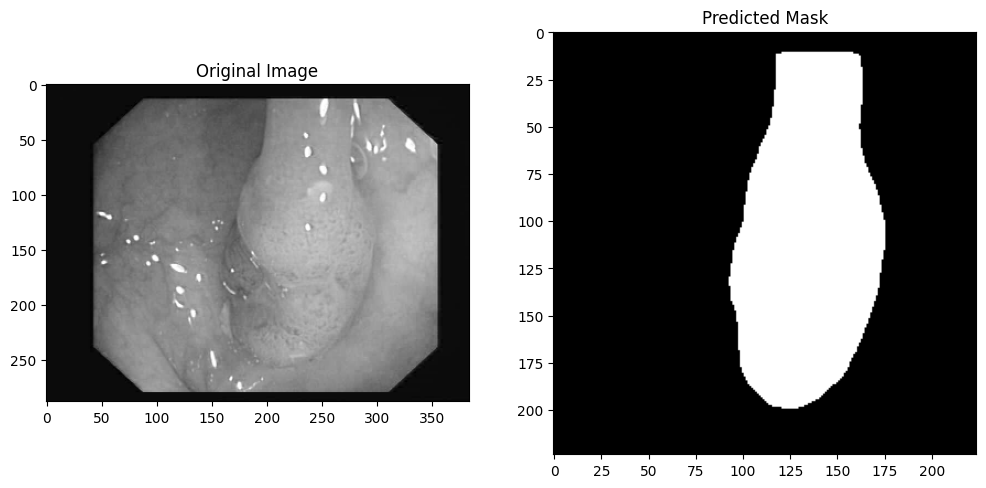

In [18]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/113.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


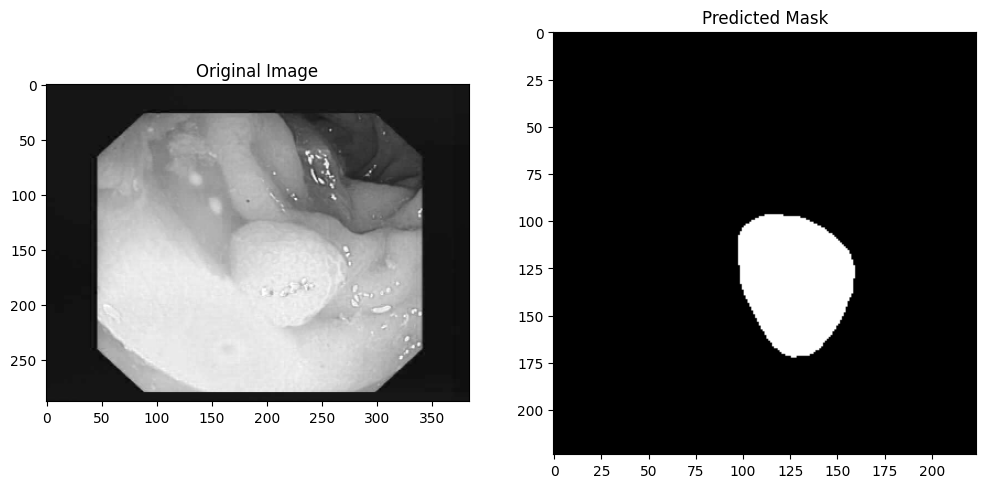

In [19]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/102.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


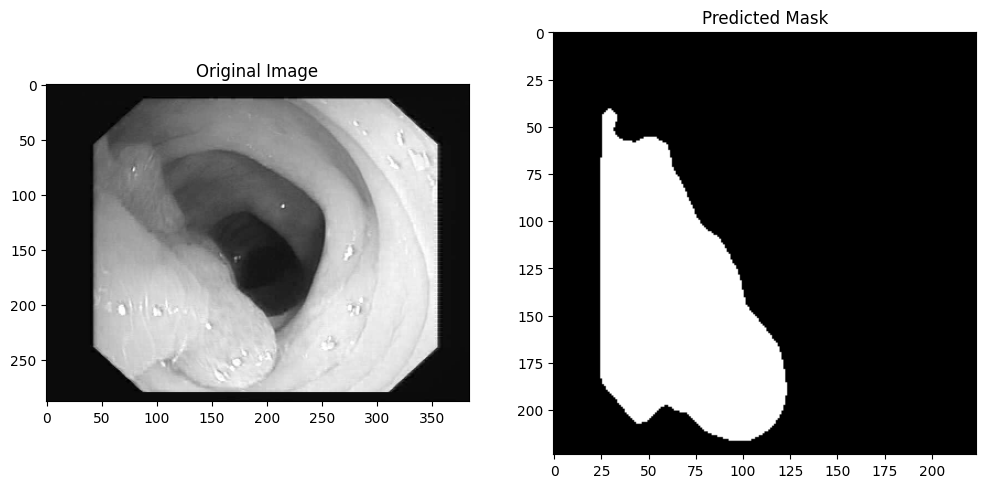

In [20]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/12.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


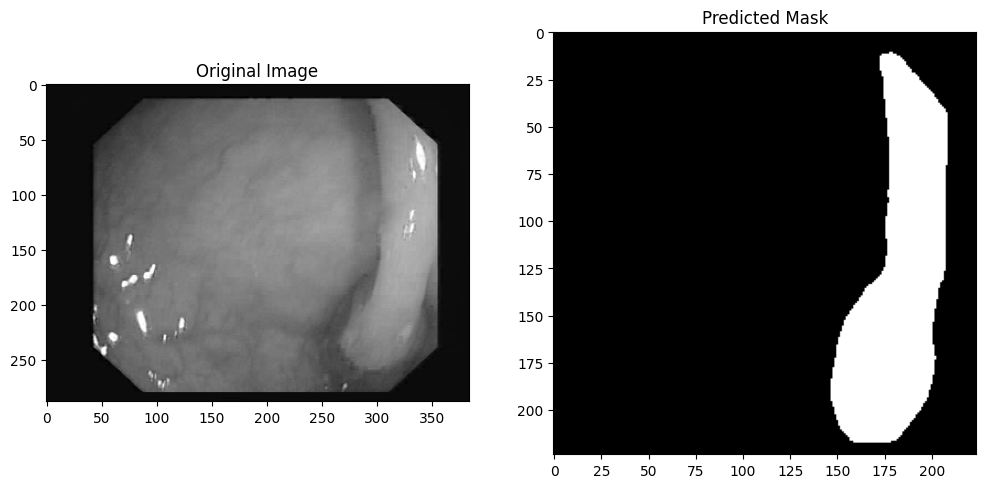

In [21]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/122.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


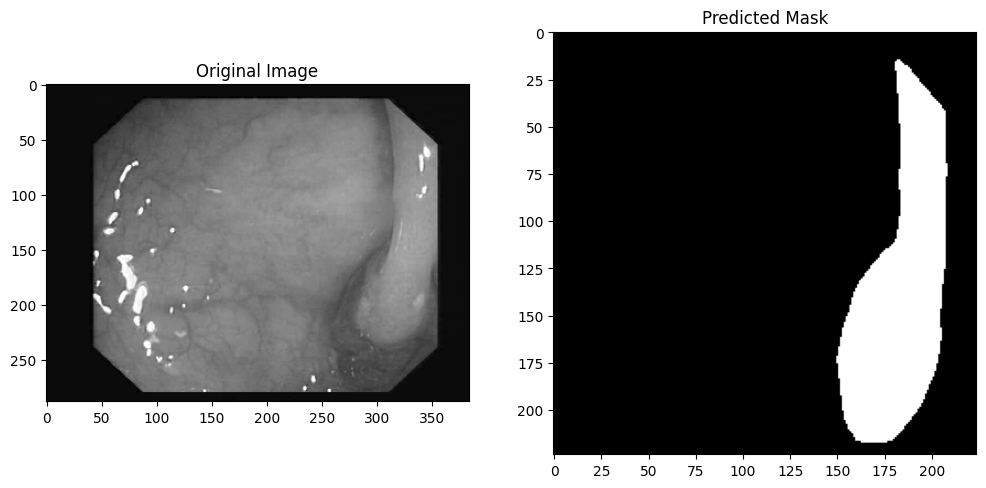

In [22]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/123.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


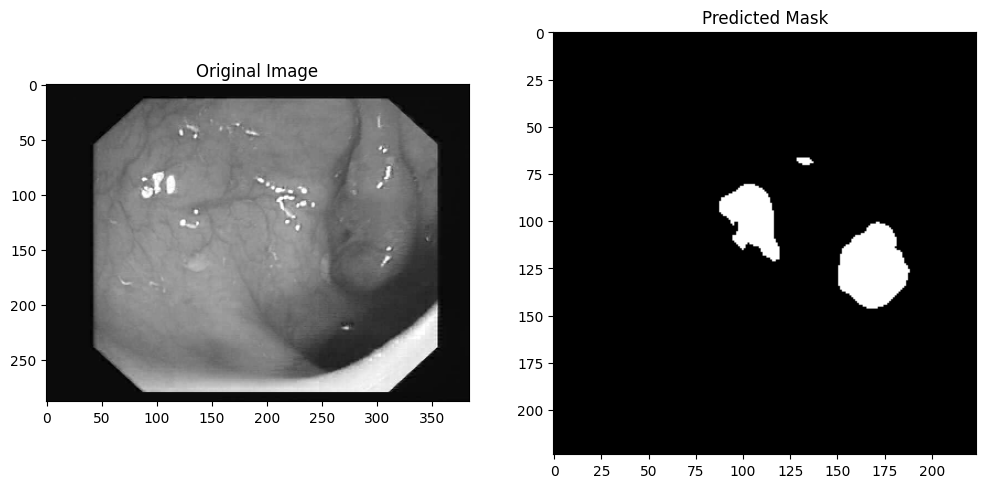

In [23]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/125.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


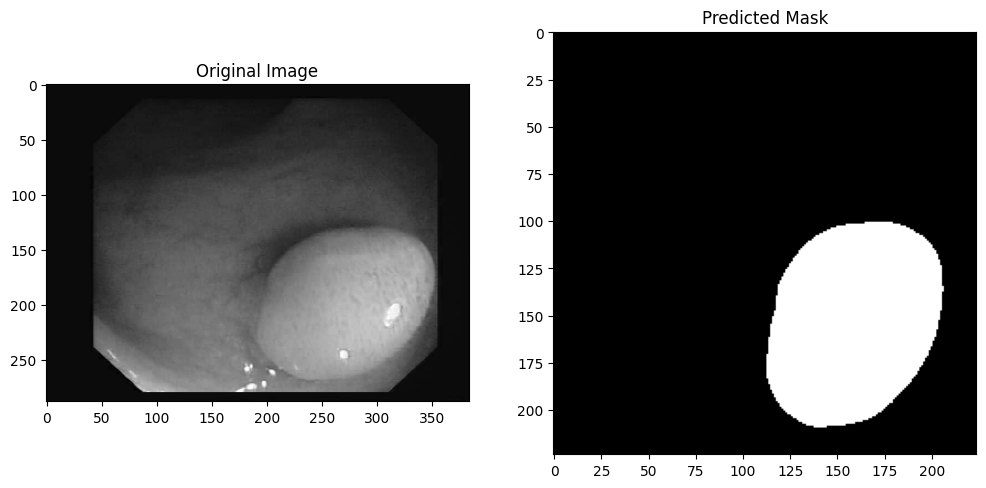

In [24]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/138.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)


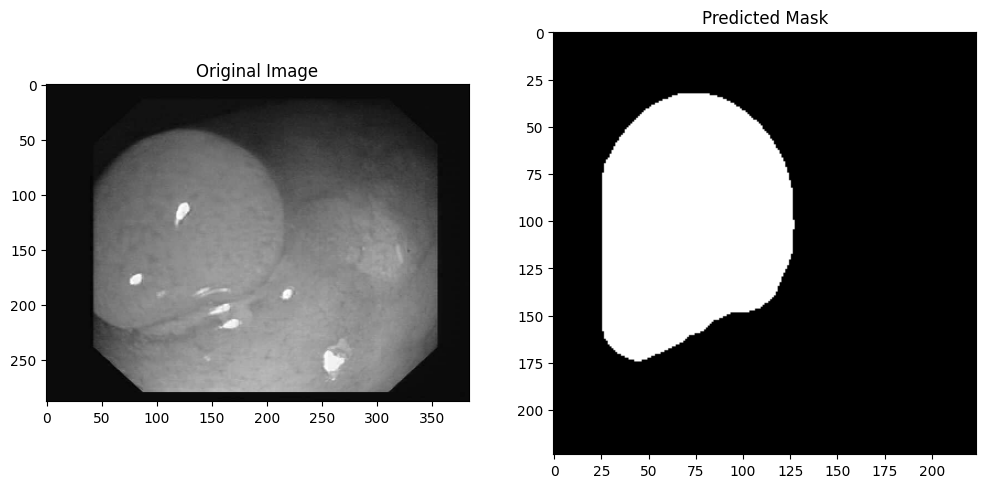

In [25]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, device='cpu'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = val_transform(image=img)['image']

    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)  # Convert to CxHxW
    
    
    img = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)  # Move input tensor to the same device as the model
        output = model(img_tensor)
    return output.squeeze().cpu().numpy()  # Move output back to CPU

def visualize_mask(img_path, predicted_mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()
    
def binarize_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return binary_mask

# Define paths
image_path = '/kaggle/input/cvcclinicdb/TIF/Original/142.tif'  

# Load and preprocess image
img_tensor = load_image(image_path, val_transform, device=device)

# Load your trained model
# model = YourModel()  # Initialize your model
# model.load_state_dict(torch.load('path_to_model_weights.pth'))  # Load model weights
# model.to(device)  # Ensure the model is on the same device

# Predict mask
predicted_mask = predict_mask(model, img_tensor)
binary_mask = binarize_mask(predicted_mask, threshold=0.5)
# Visualize results
visualize_mask(image_path, binary_mask)
